In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np


In [2]:

class MCCPWMEnvelopeDataset(Dataset):
    def __init__(self, num_samples=10000, L1=4, L2=2, TPWM=1e-4, Fs=1e6, 
                 dimming_D=0.6, SNR_dB=None):
        """
        Faithful implementation of MCC-LS waveform with PWM envelope:
        - BPM: position of the beacon (L1)
        - BPSK: phase of the beacon (L2)
        """
        self.num_samples = num_samples
        self.L1 = L1
        self.L2 = L2
        self.TPWM = TPWM
        self.Fs = Fs
        self.dimming_D = dimming_D
        self.SNR_dB = SNR_dB

        # Derived parameters
        self.samples_per_pwm = int(self.TPWM * self.Fs)
        self.Tb = self.L2 * TPWM
        self.samples_per_beacon = self.L2 * self.samples_per_pwm
        self.T_MCC = self.L1 * self.Tb
        self.total_samples = self.L1 * self.L2 * self.samples_per_pwm

    def _generate_beacon_pwm(self, phase_class):
        """
        Generate BPSK-modulated beacon -> sampled PWM -> binary waveform
        Returns a waveform of length `samples_per_beacon`.
        """
        # Time vector for beacon
        t = np.linspace(0, self.Tb, self.samples_per_beacon, endpoint=False)

        # Phase modulation (Eq. 3–4)
        if self.L2 > 2:
            theta_n = (2 * phase_class - 1) * np.pi / self.L2
        else:
            theta_n = (1 - phase_class) * np.pi

        b_t = np.sin(2 * np.pi * t / self.Tb + theta_n)  # Eq. (3)
        b_min, b_max = b_t.min(), b_t.max()

        # Convert to PWM waveform: binary high/low
        pwm_wave = np.zeros_like(b_t)
        for i, sample in enumerate(b_t):
            high_duration = (sample - b_min) / (b_max - b_min)  # Eq. (7)
            high_samples = int(high_duration * self.samples_per_pwm)
            start = i * self.samples_per_pwm
            pwm_wave[start:start + high_samples] = 1

        return pwm_wave

    def _generate_dimming_pwm(self):
        """
        Generate a dimming-only PWM waveform for the entire MCC duration.
        """
        pwm = np.zeros(self.samples_per_pwm)
        high_samples = int(self.dimming_D * self.samples_per_pwm)
        pwm[:high_samples] = 1

        num_tiles = self.total_samples // self.samples_per_pwm
        return np.tile(pwm, num_tiles)

    def _generate_ppm_mask(self, position_class):
        """
        Generate xPPM(t): a mask that is 1 only at the BPM slot.
        Used in final PWM envelope combination (Eq. 12).
        """
        ppm_mask = np.zeros(self.total_samples)
        start = position_class * self.samples_per_beacon
        ppm_mask[start:start + self.samples_per_beacon] = 1
        return ppm_mask

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random labels
        phase_class = np.random.randint(0, self.L2)
        position_class = np.random.randint(0, self.L1)

        # Generate components
        beacon_pwm = self._generate_beacon_pwm(phase_class)
        dimming_pwm = self._generate_dimming_pwm()
        ppm_mask = self._generate_ppm_mask(position_class)

        # Step 1: Copy dimming PWM as base
        vpwme = dimming_pwm.copy()

        # Step 2: Overwrite beacon slot with beacon PWM
        start = position_class * self.samples_per_beacon
        end = start + self.samples_per_beacon
        vpwme[start:end] = beacon_pwm  # overwrite region

        # Final step: normalize to [-1, 1]
        waveform = 2 * vpwme - 1

        # Optional AWGN
        if self.SNR_dB is not None:
            power = np.mean(waveform ** 2)
            snr_linear = 10 ** (self.SNR_dB / 10)
            noise_power = power / snr_linear
            noise = np.random.normal(0, np.sqrt(noise_power), waveform.shape)
            waveform += noise

        return {
            'waveform': torch.tensor(waveform, dtype=torch.float32),
            'phase_label': torch.tensor(phase_class, dtype=torch.long),
            'position_label': torch.tensor(position_class, dtype=torch.long)
        }


In [3]:
dataset = MCCPWMEnvelopeDataset(
    num_samples=100,
    L1=4,
    L2=2,
    TPWM=1e-4,
    Fs=1e6,
    dimming_D=0.6,
    SNR_dB=10
)

sample = dataset[0]
print("Waveform shape:", sample['waveform'].shape)


Waveform shape: torch.Size([800])


In [4]:
import matplotlib.pyplot as plt

def plot_mcc_waveform(dataset, index=0, title="MCC-LS PWM Envelope"):
    """
    Plot a single MCC-LS waveform from the dataset with annotations.
    """
    sample = dataset[index]
    waveform = sample['waveform'].numpy()
    phase_label = sample['phase_label'].item()
    position_label = sample['position_label'].item()

    plt.figure(figsize=(12, 3))
    plt.plot(waveform, linewidth=1.0)
    plt.title(f"{title} | Phase: {phase_label}, Position: {position_label}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Draw vertical lines to indicate BPM slots
    L1 = dataset.L1
    L2 = dataset.L2
    slot_width = dataset.samples_per_beacon
    for i in range(L1 + 1):
        plt.axvline(i * slot_width, color='red', linestyle='--', linewidth=0.5)

    # Highlight the beacon slot
    beacon_start = position_label * slot_width
    beacon_end = beacon_start + slot_width
    plt.axvspan(beacon_start, beacon_end, color='yellow', alpha=0.2, label='BPM slot')

    plt.legend()
    plt.tight_layout()
    plt.show()


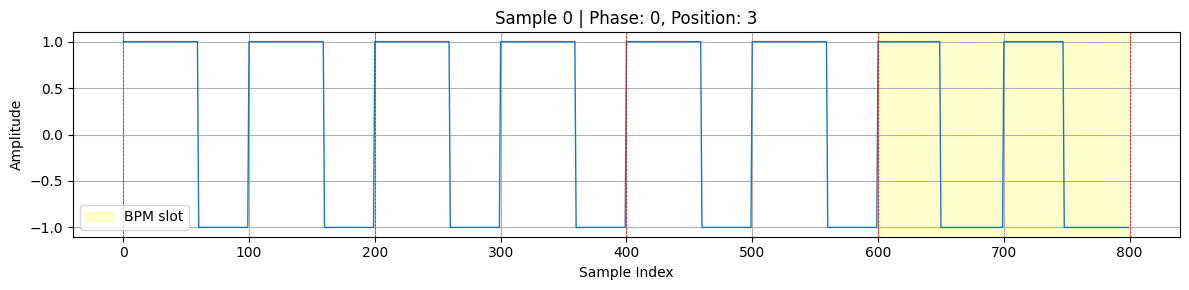

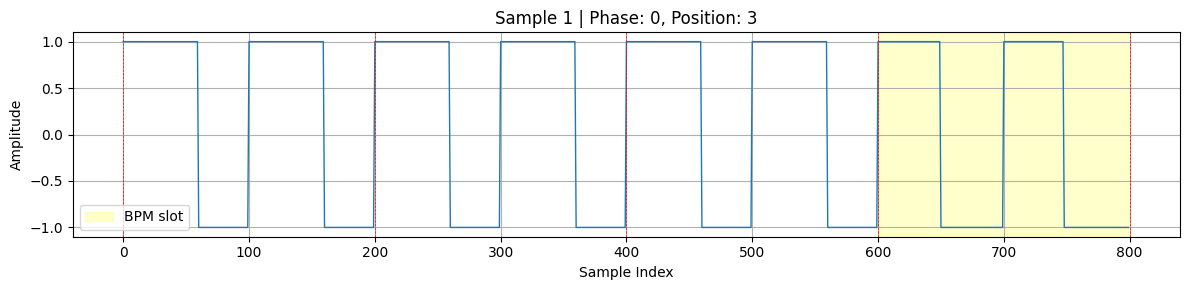

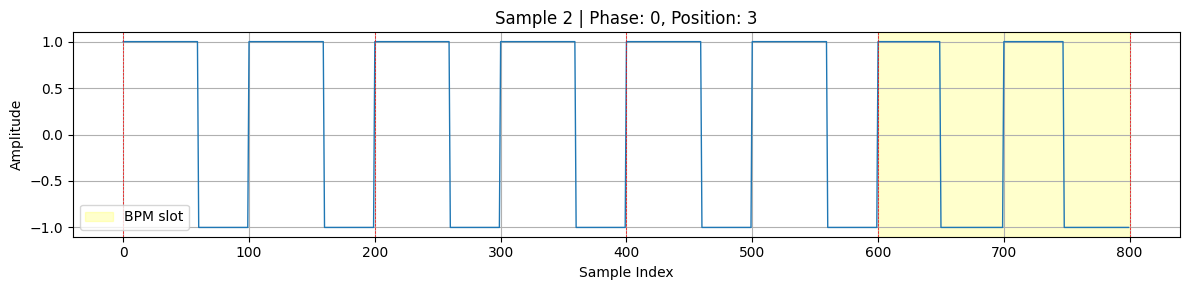

In [5]:
dataset = MCCPWMEnvelopeDataset(
    num_samples=10,
    L1=4,
    L2=2,
    TPWM=1e-4,
    Fs=1e6,
    dimming_D=0.6,
    SNR_dB=None  # Clean waveform
)

# Plot multiple samples
for i in range(3):
    plot_mcc_waveform(dataset, index=i, title=f"Sample {i}")


In [6]:
import torch
import torch.nn as nn

class CrossStitchUnit(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Learnable alpha parameters: 2x2 matrix for 2 tasks
        self.alpha = nn.Parameter(torch.tensor([[0.9, 0.1], [0.1, 0.9]]))
        self.num_features = num_features

    def forward(self, x1, x2):
        # Each x shape: (batch_size, num_features)
        mixed_1 = self.alpha[0, 0] * x1 + self.alpha[0, 1] * x2
        mixed_2 = self.alpha[1, 0] * x1 + self.alpha[1, 1] * x2
        return mixed_1, mixed_2


In [7]:
class MCCCrossStitchMTL(nn.Module):
    def __init__(self, input_dim, hidden_dim, L1, L2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        # Task-specific initial layers
        self.task1_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.task2_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.cross_stitch = CrossStitchUnit(hidden_dim)

        # Final classification heads
        self.task1_head = nn.Linear(hidden_dim, L2)  # BPSK phase
        self.task2_head = nn.Linear(hidden_dim, L1)  # BPM position

    def forward(self, x):
        shared_feat = self.shared(x)
        t1 = self.task1_branch(shared_feat)
        t2 = self.task2_branch(shared_feat)

        # Cross-stitch mixing
        t1_mix, t2_mix = self.cross_stitch(t1, t2)

        out1 = self.task1_head(t1_mix)
        out2 = self.task2_head(t2_mix)

        return out1, out2


In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = MCCCrossStitchMTL(
    input_dim=800,  # waveform length
    hidden_dim=256,
    L1=4,
    L2=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [9]:
def train_mtl(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    losses = []
    phase_accs = []
    pos_accs = []
    for epoch in range(epochs):
        total_loss = 0
        correct_phase = 0
        correct_pos = 0
        total = 0

        for batch in dataloader:
            x = batch['waveform'].to(device)
            y_phase = batch['phase_label'].to(device)
            y_pos = batch['position_label'].to(device)

            optimizer.zero_grad()
            out_phase, out_pos = model(x)

            loss_phase = criterion(out_phase, y_phase)
            loss_pos = criterion(out_pos, y_pos)
            loss = loss_phase + loss_pos
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_phase += (out_phase.argmax(dim=1) == y_phase).sum().item()
            correct_pos += (out_pos.argmax(dim=1) == y_pos).sum().item()
            total += x.size(0)

        losses.append(total_loss)
        phase_accs.append(correct_phase / total)
        pos_accs.append(correct_pos / total)

        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | "
              f"Phase Acc: {correct_phase/total:.2%} | "
              f"Pos Acc: {correct_pos/total:.2%}")
        
    return losses, phase_accs, pos_accs


In [10]:
from torch.utils.data import DataLoader

dataset = MCCPWMEnvelopeDataset(num_samples=10000, L1=4, L2=2)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [11]:
losses, phase_accs, pos_accs = train_mtl(model, dataloader, optimizer, criterion, epochs=20)

[Epoch 1] Loss: 77.5779 | Phase Acc: 80.14% | Pos Acc: 97.13%
[Epoch 2] Loss: 0.5516 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 3] Loss: 0.1278 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 4] Loss: 0.0585 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 5] Loss: 0.0332 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 6] Loss: 0.0212 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 7] Loss: 0.0146 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 8] Loss: 0.0106 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 9] Loss: 0.0081 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 10] Loss: 0.0063 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 11] Loss: 0.0050 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 12] Loss: 0.0041 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 13] Loss: 0.0033 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 14] Loss: 0.0028 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 15] Loss: 0.0023 | Phase Acc: 100.00% | Pos Acc: 100.00%
[Epoch 16] Loss: 0.0020 | Phase Acc: 100.00% | Pos

In [12]:
alpha = model.cross_stitch.alpha.detach().cpu().numpy()
print("Cross-Stitch Weights:")
print(f"[T1 → T1]: {alpha[0,0]:.4f} | [T1 → T2]: {alpha[1,0]:.4f}")
print(f"[T2 → T1]: {alpha[0,1]:.4f} | [T2 → T2]: {alpha[1,1]:.4f}")


Cross-Stitch Weights:
[T1 → T1]: 1.0848 | [T1 → T2]: 0.1432
[T2 → T1]: 0.1945 | [T2 → T2]: 0.9483


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, L1, L2, title="Confusion Matrices"):
    model.eval()
    all_phase_preds, all_phase_true = [], []
    all_pos_preds, all_pos_true = [], []

    with torch.no_grad():
        for batch in dataloader:
            x = batch['waveform'].to(device)
            y_phase = batch['phase_label'].to(device)
            y_pos = batch['position_label'].to(device)

            out_phase, out_pos = model(x)
            phase_preds = out_phase.argmax(dim=1).cpu().numpy()
            pos_preds = out_pos.argmax(dim=1).cpu().numpy()

            all_phase_preds.extend(phase_preds)
            all_phase_true.extend(y_phase.cpu().numpy())
            all_pos_preds.extend(pos_preds)
            all_pos_true.extend(y_pos.cpu().numpy())

    # Classification Reports
    print("Phase Classification Report:")
    print(classification_report(all_phase_true, all_phase_preds, digits=4))

    print("\nPosition Classification Report:")
    print(classification_report(all_pos_true, all_pos_preds, digits=4))

    # Confusion Matrices
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(confusion_matrix(all_phase_true, all_phase_preds), 
                annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Phase Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(confusion_matrix(all_pos_true, all_pos_preds), 
                annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title("Position Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


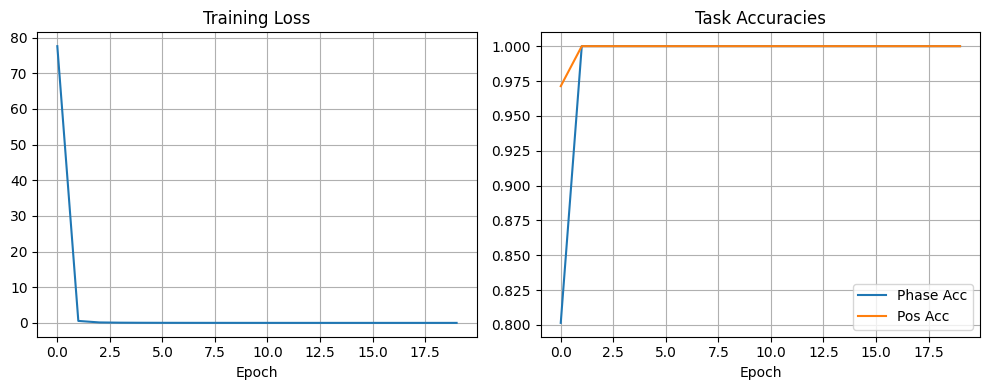

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(phase_accs, label='Phase Acc')
plt.plot(pos_accs, label='Pos Acc')
plt.title("Task Accuracies")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
def generate_snrs(start=0, stop=30, step=5):
    return list(range(start, stop + 1, step))

def evaluate_over_snr(model, base_dataset, snr_levels, batch_size=128):
    acc_phase = []
    acc_pos = []
    
    for snr in snr_levels:
        print(f"\n[SNR = {snr} dB]")

        test_dataset = MCCPWMEnvelopeDataset(
            num_samples=2000,
            L1=base_dataset.L1,
            L2=base_dataset.L2,
            TPWM=base_dataset.TPWM,
            Fs=base_dataset.Fs,
            dimming_D=base_dataset.dimming_D,
            SNR_dB=snr
        )

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        model.eval()
        
        correct_phase = 0
        correct_pos = 0
        total = 0

        all_phase_preds = []
        all_phase_true = []

        all_pos_preds = []
        all_pos_true = []

        with torch.no_grad():
            for batch in test_loader:
                x = batch['waveform'].to(device)
                y_phase = batch['phase_label'].to(device)
                y_pos = batch['position_label'].to(device)

                out_phase, out_pos = model(x)
                p_pred = out_phase.argmax(dim=1)
                pos_pred = out_pos.argmax(dim=1)

                correct_phase += (p_pred == y_phase).sum().item()
                correct_pos += (pos_pred == y_pos).sum().item()
                total += x.size(0)

                all_phase_preds.extend(p_pred.cpu().numpy())
                all_phase_true.extend(y_phase.cpu().numpy())
                all_pos_preds.extend(pos_pred.cpu().numpy())
                all_pos_true.extend(y_pos.cpu().numpy())

        acc_phase.append(correct_phase / total)
        acc_pos.append(correct_pos / total)

        print(f"Phase Acc: {acc_phase[-1]:.4f} | Pos Acc: {acc_pos[-1]:.4f}")

        # Plot confusion matrices at selected SNRs
        if snr in [0, 10, 30]:
            evaluate_confusions(all_phase_true, all_phase_preds, all_pos_true, all_pos_preds, snr)

    return acc_phase, acc_pos


In [16]:
def evaluate_confusions(y_phase_true, y_phase_pred, y_pos_true, y_pos_pred, snr):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(confusion_matrix(y_phase_true, y_phase_pred),
                annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"BPSK Phase Confusion (SNR={snr} dB)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(confusion_matrix(y_pos_true, y_pos_pred),
                annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title(f"BPM Position Confusion (SNR={snr} dB)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

def plot_snr_curve(snr_levels, acc_phase, acc_pos):
    plt.figure(figsize=(7, 4))
    plt.plot(snr_levels, acc_phase, marker='o', label='Phase Accuracy')
    plt.plot(snr_levels, acc_pos, marker='s', label='Position Accuracy')
    plt.xlabel("SNR (dB)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs SNR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



[SNR = 0 dB]
Phase Acc: 0.8335 | Pos Acc: 1.0000


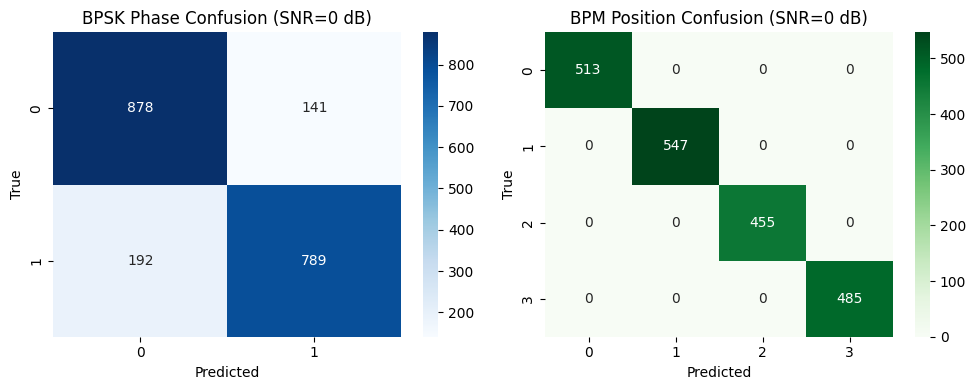


[SNR = 5 dB]
Phase Acc: 0.9380 | Pos Acc: 1.0000

[SNR = 10 dB]
Phase Acc: 0.9985 | Pos Acc: 1.0000


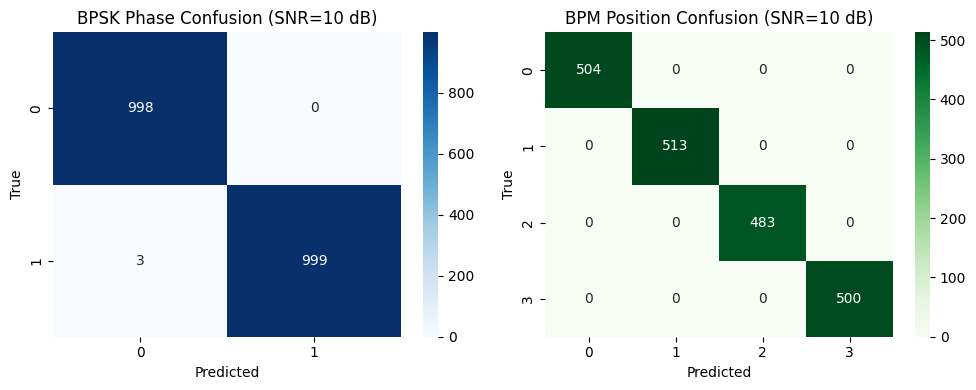


[SNR = 15 dB]
Phase Acc: 1.0000 | Pos Acc: 1.0000

[SNR = 20 dB]
Phase Acc: 1.0000 | Pos Acc: 1.0000

[SNR = 25 dB]
Phase Acc: 1.0000 | Pos Acc: 1.0000

[SNR = 30 dB]
Phase Acc: 1.0000 | Pos Acc: 1.0000


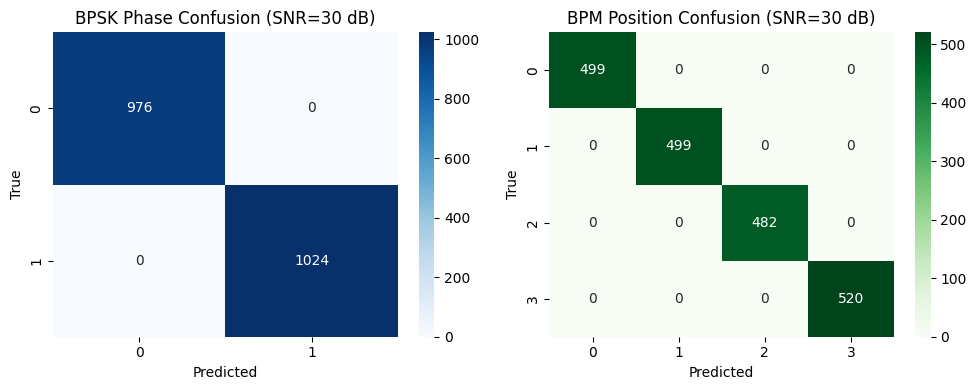

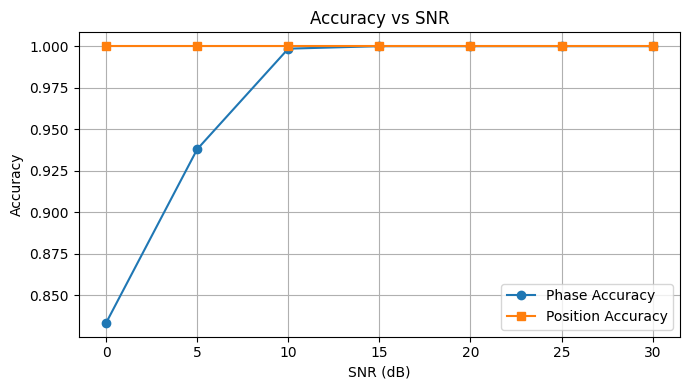

In [17]:
snr_levels = generate_snrs(0, 30, step=5)
acc_phase, acc_pos = evaluate_over_snr(model, dataset, snr_levels)
plot_snr_curve(snr_levels, acc_phase, acc_pos)


In [18]:
class SharedMTL(nn.Module):
    def __init__(self, input_dim, hidden_dim, L1, L2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.phase_head = nn.Linear(hidden_dim, L2)
        self.pos_head = nn.Linear(hidden_dim, L1)

    def forward(self, x):
        features = self.shared(x)
        return self.phase_head(features), self.pos_head(features)

class SplitMTL(nn.Module):
    def __init__(self, input_dim, hidden_dim, L1, L2):
        super().__init__()
        self.phase_branch = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, L2)
        )
        self.pos_branch = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, L1)
        )

    def forward(self, x):
        return self.phase_branch(x), self.pos_branch(x)


In [19]:
def train_and_eval_model(model, dataset, name="Model", epochs=10, batch_size=64):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    phase_accs = []
    pos_accs = []
    alpha_history = [] if hasattr(model, 'cross_stitch') else None

    for epoch in range(epochs):
        model.train()
        total_loss, correct_phase, correct_pos, total = 0, 0, 0, 0

        for batch in dataloader:
            x = batch['waveform'].to(device)
            y_phase = batch['phase_label'].to(device)
            y_pos = batch['position_label'].to(device)

            optimizer.zero_grad()
            out_phase, out_pos = model(x)
            loss = criterion(out_phase, y_phase) + criterion(out_pos, y_pos)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_phase += (out_phase.argmax(1) == y_phase).sum().item()
            correct_pos += (out_pos.argmax(1) == y_pos).sum().item()
            total += x.size(0)

        losses.append(total_loss)
        phase_accs.append(correct_phase / total)
        pos_accs.append(correct_pos / total)

        print(f"[{name} | Epoch {epoch+1}] Loss: {total_loss:.4f} | "
              f"Phase Acc: {phase_accs[-1]:.4f} | Pos Acc: {pos_accs[-1]:.4f}")


        if hasattr(model, 'cross_stitch'):
            alpha_history.append(model.cross_stitch.alpha.detach().cpu().numpy().copy())

    return model, losses, phase_accs, pos_accs, alpha_history


In [20]:
hidden_dim = 256
input_dim = 800
L1, L2 = 4, 2
epochs = 20

shared_model = SharedMTL(input_dim, hidden_dim, L1, L2)
split_model = SplitMTL(input_dim, hidden_dim, L1, L2)
xstitch_model = MCCCrossStitchMTL(input_dim, hidden_dim, L1, L2)

dataset = MCCPWMEnvelopeDataset(num_samples=10000, L1=L1, L2=L2)

# Train all three
shared_model, loss_s, acc_p_s, acc_b_s, _ = train_and_eval_model(shared_model, dataset, name="Shared", epochs=epochs)
split_model, loss_sp, acc_p_sp, acc_b_sp, _ = train_and_eval_model(split_model, dataset, name="Split", epochs=epochs)
xstitch_model, loss_x, acc_p_x, acc_b_x, alpha_xstitch= train_and_eval_model(xstitch_model, dataset, name="CrossStitch", epochs=epochs)


[Shared | Epoch 1] Loss: 73.2536 | Phase Acc: 0.8325 | Pos Acc: 0.9830
[Shared | Epoch 2] Loss: 0.8142 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 3] Loss: 0.2044 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 4] Loss: 0.0970 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 5] Loss: 0.0567 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 6] Loss: 0.0372 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 7] Loss: 0.0259 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 8] Loss: 0.0190 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 9] Loss: 0.0144 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 10] Loss: 0.0112 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 11] Loss: 0.0089 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 12] Loss: 0.0072 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 13] Loss: 0.0060 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoch 14] Loss: 0.0049 | Phase Acc: 1.0000 | Pos Acc: 1.0000
[Shared | Epoc

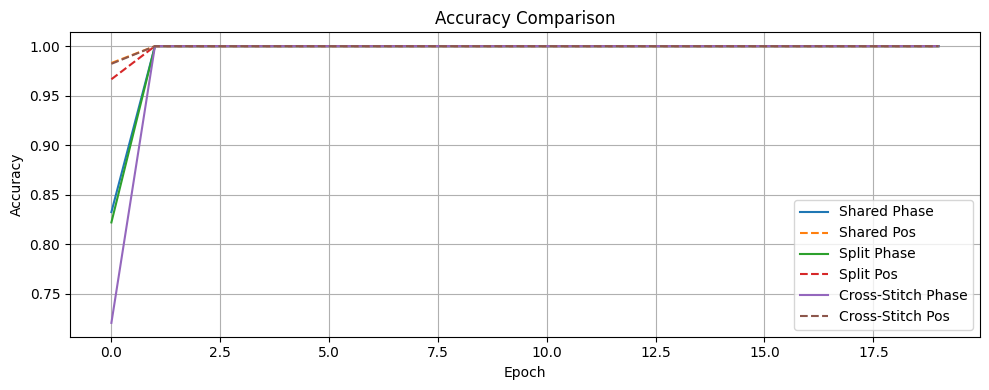

In [21]:
def plot_model_comparisons(acc_p_all, acc_b_all, labels, title="Accuracy Comparison"):
    plt.figure(figsize=(10, 4))
    for acc_p, acc_b, label in zip(acc_p_all, acc_b_all, labels):
        plt.plot(acc_p, label=f"{label} Phase")
        plt.plot(acc_b, label=f"{label} Pos", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_model_comparisons(
    [acc_p_s, acc_p_sp, acc_p_x],
    [acc_b_s, acc_b_sp, acc_b_x],
    labels=["Shared", "Split", "Cross-Stitch"]
)


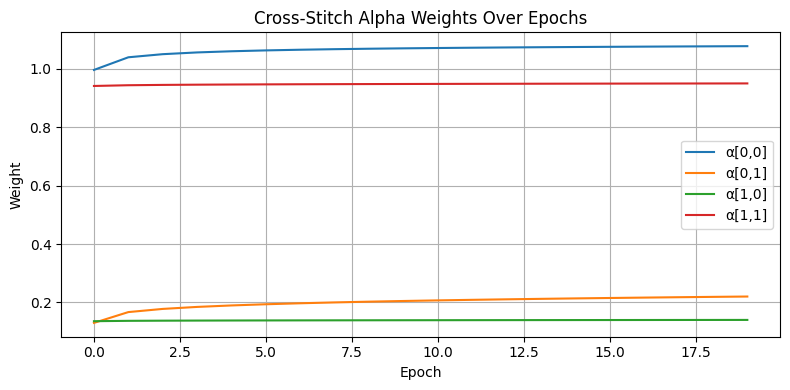

In [22]:
def plot_alpha_history(alpha_history):
    alpha_array = np.stack(alpha_history)  # (epochs, 2, 2)

    plt.figure(figsize=(8, 4))
    for i in range(2):
        for j in range(2):
            plt.plot(alpha_array[:, i, j], label=f"α[{i},{j}]")

    plt.title("Cross-Stitch Alpha Weights Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Weight")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_alpha_history(alpha_xstitch)


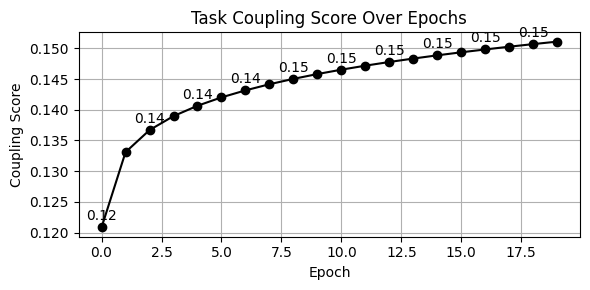

In [23]:
def coupling_scores(alpha_history):
    """
    Returns a list of coupling scores over time.
    coupling = (α12 + α21) / total α sum
    """
    scores = []
    for alpha in alpha_history:
        cross = alpha[0, 1] + alpha[1, 0]
        total = alpha.sum()
        scores.append(cross / total)
    return scores

def plot_coupling_trend(scores):
    plt.figure(figsize=(6, 3))
    plt.plot(scores, marker='o', color='black')
    plt.title("Task Coupling Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Coupling Score")
    plt.grid(True)

    for i, s in enumerate(scores):
        if i % max(1, len(scores)//10) == 0:  # annotate ~10 points
            plt.annotate(f"{s:.2f}", (i, s), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.tight_layout()
    plt.show()


scores = coupling_scores(alpha_xstitch)
plot_coupling_trend(scores)

In [24]:
def plot_alpha_history(alpha_history):
    alpha_array = np.stack(alpha_history)  # shape: (epochs, 2, 2)
    epochs = len(alpha_array)

    plt.figure(figsize=(8, 4))
    labels = [["α₁₁ (T1→T1)", "α₁₂ (T2→T1)"], ["α₂₁ (T1→T2)", "α₂₂ (T2→T2)"]]
    
    for i in range(2):
        for j in range(2):
            values = alpha_array[:, i, j]
            plt.plot(values, label=labels[i][j], marker='.')
    
    plt.title("Cross-Stitch α Weights Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Weight Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
def plot_alpha_heatmap_stack(alpha_history):
    alpha_array = np.stack(alpha_history)  # shape: (epochs, 2, 2)
    # Reshape to (epochs, 4)
    flat = alpha_array.reshape(len(alpha_array), -1)

    plt.figure(figsize=(6, 4))
    sns.heatmap(flat.T, annot=True, cmap="viridis", fmt=".2f", cbar=True,
                yticklabels=["α₁₁", "α₁₂", "α₂₁", "α₂₂"])
    plt.title("Cross-Stitch α Matrix Evolution")
    plt.xlabel("Epoch")
    plt.ylabel("Matrix Entry")
    plt.tight_layout()
    plt.show()


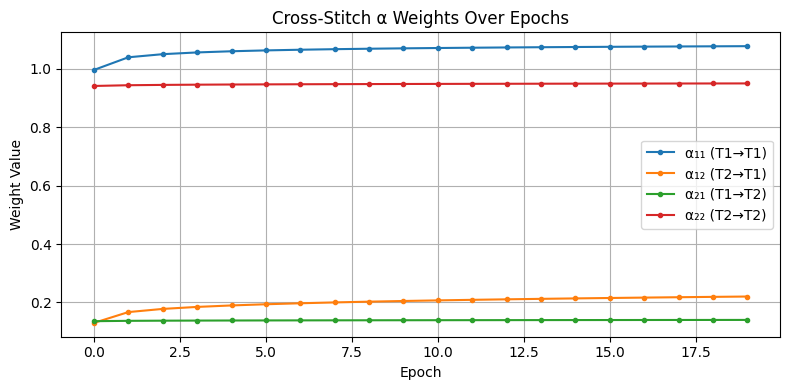

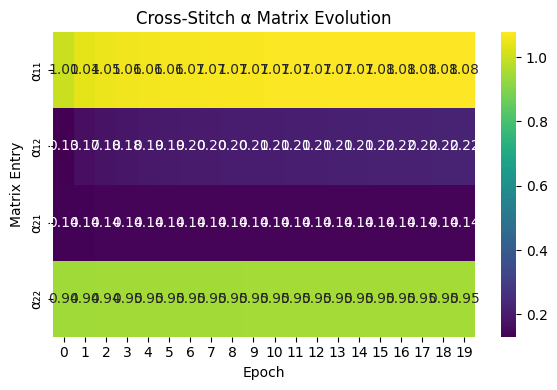

In [26]:

plot_alpha_history(alpha_xstitch)
plot_alpha_heatmap_stack(alpha_xstitch)


In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_split = count_parameters(split_model)
params_xstitch = count_parameters(xstitch_model)

print(f"Split Model Params:       {params_split:,}")
print(f"Cross-Stitch Model Params: {params_xstitch:,}")



Split Model Params:       543,238
Cross-Stitch Model Params: 338,186


In [28]:
import time

def measure_inference_time(model, input_tensor, reps=100):
    model.eval()
    input_tensor = input_tensor.to(next(model.parameters()).device)

    with torch.no_grad():
        # Warm-up
        for _ in range(10):
            _ = model(input_tensor)

        start = time.time()
        for _ in range(reps):
            _ = model(input_tensor)
        end = time.time()

    avg_time_ms = (end - start) / reps * 1000
    return avg_time_ms

dummy_input = torch.randn(1, 800).to(device)
print(f"Split Inference Time: {measure_inference_time(split_model, dummy_input):.3f} ms")
print(f"X-Stitch Inference Time: {measure_inference_time(xstitch_model, dummy_input):.3f} ms")


Split Inference Time: 0.233 ms
X-Stitch Inference Time: 0.335 ms


In [29]:
from torchinfo import summary
summary(xstitch_model, input_size=(1, 800))
summary(split_model, input_size=(1, 800))


Layer (type:depth-idx)                   Output Shape              Param #
SplitMTL                                 [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 256]                  205,056
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Linear: 2-3                       [1, 256]                  65,792
│    └─ReLU: 2-4                         [1, 256]                  --
│    └─Linear: 2-5                       [1, 2]                    514
├─Sequential: 1-2                        [1, 4]                    --
│    └─Linear: 2-6                       [1, 256]                  205,056
│    └─ReLU: 2-7                         [1, 256]                  --
│    └─Linear: 2-8                       [1, 256]                  65,792
│    └─ReLU: 2-9                         [1, 256]                  --
│    └─Linear: 2-10                      [1, 4]                   

In [32]:
from fvcore.nn import FlopCountAnalysis, parameter_count
import torch

def profile_model(model, input_shape=(1, 800)):
    model.eval()
    dummy_input = torch.randn(*input_shape).to(next(model.parameters()).device)

    flops = FlopCountAnalysis(model, dummy_input)
    params = parameter_count(model)

    total_flops = flops.total()
    total_params = list(params.values())[0]  # direct integer

    print(f"Total FLOPs:  {total_flops / 1e6:.2f} MFLOPs")
    print(f"Total Params: {total_params:,}")
    return total_flops, total_params


In [33]:
flops_split, params_split = profile_model(split_model)
flops_xstitch, params_xstitch = profile_model(xstitch_model)


Unsupported operator aten::mul encountered 4 time(s)
Unsupported operator aten::add encountered 2 time(s)


Total FLOPs:  0.54 MFLOPs
Total Params: 543,238
Total FLOPs:  0.34 MFLOPs
Total Params: 338,186
